In [8]:
from transformers import RagTokenizer, RagRetriever, RagTokenForGeneration, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("facebook/rag-token-nq")
retriever = RagRetriever.from_pretrained("facebook/rag-token-nq", index_name="compressed") # index_name="exact", use_dummy_dataset=True
model = RagTokenForGeneration.from_pretrained("facebook/rag-token-nq", retriever=retriever)

/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is cal

In [2]:
input_dict = tokenizer.prepare_seq2seq_batch("who was the first US president?", return_tensors="pt") 

generated = model.generate(input_ids=input_dict["input_ids"]) 
print(tokenizer.batch_decode(generated, skip_special_tokens=True)[0])

/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/transformers/models/rag/tokenization_rag.py:87: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/transformers/generation/utils.py:3020: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


 george washington


In [3]:
from dataset import HallucinationDataset
from torch.utils.data import DataLoader

from functools import partial

def find_definition(text):
    return text[text.find("<define>") + 9: text.find(" </define>")]

def collate_dm(batch, add_context=False):
    questions = []
    hyp = []
    label = []

    for elem in batch:
        question = f"what is {find_definition(elem['src'])}"
        if add_context:
            context = elem["src"].replace("<define>", "").replace("</define>", "")
            question += f'. {context}'

        questions.append(question)
        hyp.append(elem["hyp"])
        label.append(elem["label"])

    res = {"question": questions, "hyp": hyp, "label": label}
    return res

train = HallucinationDataset("data/val/val.model-agnostic.json", "DM")
train_loader = DataLoader(train, batch_size=5, collate_fn=partial(collate_dm, add_context=False))

In [4]:
from transformers import MaxLengthCriteria
from tqdm.notebook import tqdm

device = "cuda:1"
model.to(device)

hyp = []
labels = []
preds = []

for batch in tqdm(train_loader):
    hyp.extend(batch["hyp"])
    labels.extend(batch["label"])
    
    input_dict = tokenizer.prepare_seq2seq_batch(batch["question"], 
                                                 return_tensors="pt", 
                                                 padding=True, truncation=True, 
                                                 max_length=40).to(device)

    generated = model.generate(**input_dict, stopping_criteria=MaxLengthCriteria(15))
    preds.extend(tokenizer.batch_decode(generated, skip_special_tokens=True))

0it [00:00, ?it/s]

### Без контекста

In [5]:
hyp[:3], preds[:3], labels[:3]

(['Resembling or characteristic of a weasel.',
  'Alternative form of sheath knife',
  '(obsolete) A short period of time.'],
 [' euphemism for jessica dicicco',
  ' a fixed - blade knife',
  ", andrews's best friend"],
 [1, 0, 1])

In [7]:
from evaluate import load
bertscore = load("bertscore")

results = bertscore.compute(predictions=hyp, references=preds, lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import torch
from torch.nn.functional import cross_entropy

labels = torch.tensor(labels).float().to(device)
preds_rag = torch.tensor(results["f1"]).to(device)
cross_entropy(preds_rag, labels)

tensor(497.8563, device='cuda:1')

In [9]:
def calculate_acc(preds, label, thr=0.85):
    return (label == (preds > thr).int()).float().mean()

calculate_acc(preds_rag, labels)

tensor(0.5936, device='cuda:1')

In [11]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels.cpu().numpy(), preds_rag.cpu().detach().numpy())

0.5865560640732266

0.5935828877005348


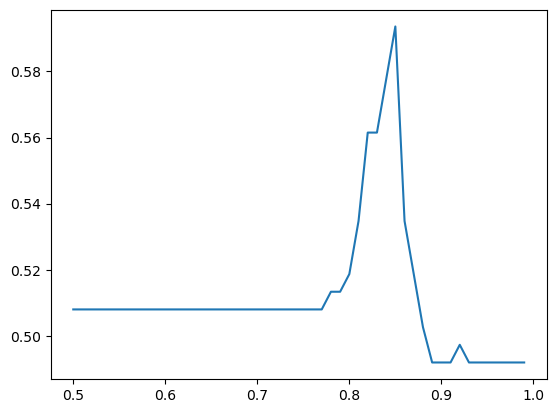

In [12]:
import numpy as np
from matplotlib import pyplot as plt

labels = labels.cpu().numpy()
preds = preds_rag.cpu().detach().numpy()

accuracy_lst = []

for threshold in np.arange(0.5, 1.0, 0.01):
    answers = [int(value) for value in np.array(preds) > threshold]
    accuracy_lst.append((np.array(labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.5, 1.0, 0.01), accuracy_lst)

#### С Sentence transformer

In [20]:
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

paraphrase = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v1')

preds = []
labels = []


for batch in tqdm(train_loader):
    labels.extend(batch["label"])
    
    input_dict = tokenizer.prepare_seq2seq_batch(batch["question"], 
                                                 return_tensors="pt", 
                                                 padding=True, truncation=True, 
                                                 max_length=40).to(device)

    generated = model.generate(**input_dict, stopping_criteria=MaxLengthCriteria(15))
    gt = tokenizer.batch_decode(generated, skip_special_tokens=True)

    hyp_emb = paraphrase.encode(batch["hyp"], convert_to_tensor=True)
    gt_emb = paraphrase.encode(gt, convert_to_tensor=True)

    pred = cosine_similarity(hyp_emb, gt_emb).cpu().detach()

    preds.extend(pred.numpy())

0it [00:00, ?it/s]

0.5989304812834224


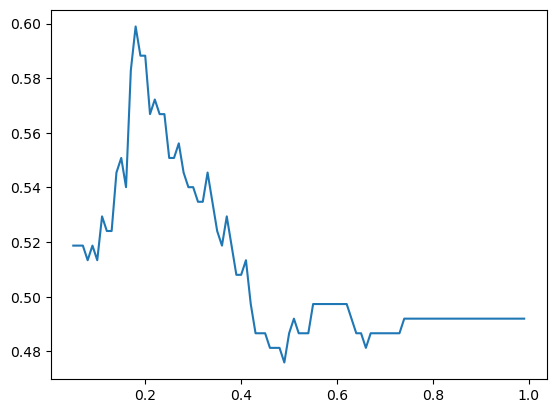

In [21]:
import numpy as np
from matplotlib import pyplot as plt

accuracy_lst = []

for threshold in np.arange(0.05, 1.0, 0.01):
    answers = [int(value) for value in np.array(preds) > threshold]
    accuracy_lst.append((np.array(labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.05, 1.0, 0.01), accuracy_lst)

### С контекстом

In [69]:
results = bertscore.compute(predictions=hyp, references=preds, lang="en")

labels = torch.tensor(labels).float().to(device)
preds_rag = torch.tensor(results["f1"]).to(device)
cross_entropy(preds_rag, labels)

tensor(500.2276, device='cuda:1')

In [70]:
calculate_acc(preds_rag, labels)

tensor(0.5615, device='cuda:1')

### Определения из вики-словаря

In [13]:
from wiktionaryparser import WiktionaryParser

parser = WiktionaryParser()

def aggregate(word):
    return word.replace(" ", "")

def get_defs(word, agg=False):
    try:
        wiki_data = parser.fetch(word)
        defs = wiki_data[0]["definitions"]
        if defs:
            for d in defs[0]["text"]:
                if "plural of" in d:
                    singular = d[d.find("of") + 3:].replace(".", "")
                    return get_defs(singular)
            return defs[0]["text"]
        else:
            if not agg:
                return get_defs(aggregate(word), True)
            else:
                return []
    except AttributeError:
        return []
        

def collate_wiki(batch):
    definitions = []
    hyp = []
    label = []

    for elem in batch:
        word = find_definition(elem['src'])
        defs = get_defs(word)

        definitions.append(defs)
        hyp.append(elem["hyp"])
        label.append(elem["label"])

    res = {"definition": definitions, "hyp": hyp, "label": label}
    return res

data = HallucinationDataset("data/val/val.model-agnostic.json", "DM")
loader = DataLoader(data, batch_size=1, collate_fn=collate_wiki)

In [14]:
get_defs("out")

['out (not comparable)',
 'Away from the inside, centre or other point of reference.',
 "Away from home or one's usual place.",
 'Outside; not indoors.',
 'Away from; at a distance.',
 'Into a state of non-operation or non-existence.',
 'To the end; completely.',
 'Used to intensify or emphasize.',
 '(of the sun, moon, stars, etc.) So as to be visible in the sky, and not covered by clouds, fog, etc.',
 '(cricket, baseball) Of a player, so as to be disqualified from playing further by some action of a member of the opposing team (such as being stumped in cricket).']

### E5 encoder

In [15]:
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

In [ ]:
from tqdm.notebook import tqdm

probs = []
labels = []

for b in tqdm(loader):
    try:
        true_defs = tokenizer(b["definition"][0], padding=True, return_tensors='pt')
        hyp_tokenized = tokenizer(b["hyp"], padding=True, return_tensors='pt')
    
        true_defs_outputs = F.normalize(average_pool(model(**true_defs).last_hidden_state, true_defs['attention_mask']), p=2, dim=1)
        hyp_outputs = F.normalize(average_pool(model(**hyp_tokenized).last_hidden_state, hyp_tokenized['attention_mask']), p=2, dim=1)
    
        hyp_def_proba = (hyp_outputs @ true_defs_outputs.T).diag().cpu().detach().numpy()
        probs.append(hyp_def_proba.max())
        labels.extend(b["label"])
    except IndexError:
        print(b)


In [21]:
from sklearn.metrics import roc_auc_score

roc_auc_score(labels, probs)

0.6534133533383347

0.6536312849162011


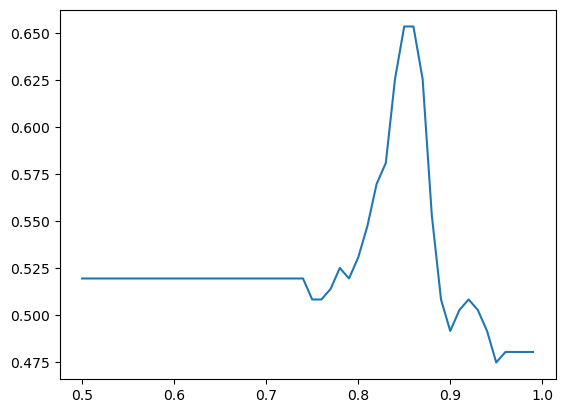

In [23]:
import numpy as np
from matplotlib import pyplot as plt

accuracy_lst = []

for threshold in np.arange(0.5, 1.0, 0.01):
    answers = [int(value) for value in np.array(probs) > threshold]
    accuracy_lst.append((np.array(labels) == np.array(answers)).mean())

print(max(accuracy_lst))

plt.plot(np.arange(0.5, 1.0, 0.01), accuracy_lst)

### natural questions

In [27]:
from datasets import load_dataset

nq = load_dataset("natural_questions", split="validation", streaming=True)

In [28]:
res = list(nq.take(100))

In [29]:
def get_dataset(num_examples):
    batch = list(nq.take(num_examples))
    
    # questions = []
    # answers = []
    q_a = []

    for entry in batch:
        curr_answers = [ans["text"][0] for ans in entry["annotations"]["short_answers"] if len(ans["text"])]

        if curr_answers:
            q_a.append((entry["question"]["text"], min(curr_answers, key=len)))
            # questions.append(entry["question"]["text"])
            # answers.append(min(curr_answers, key=len))

    return q_a #questions, answers

In [35]:
dataset[0][0]

'what purpose did seasonal monsoon winds have on trade'

In [38]:
input_dict = tokenizer(dataset[0][0], return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
print(tokenizer.batch_decode(input_dict["input_ids"]))

# generated = model.generate(**input_dict, stopping_criteria=MaxLengthCriteria(max_length))

# preds.extend(tokenizer.batch_decode(generated, skip_special_tokens=True))
# answers.extend(a)


[' like http Care tour transcriptBest entrance choice identifieditaa']


In [31]:
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import DataLoader


def run_inference(rank, world_size):
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    
    retriever = RagRetriever.from_pretrained("facebook/rag-token-nq", index_name="exact", use_dummy_dataset=True)
    model = RagTokenForGeneration.from_pretrained("facebook/rag-token-nq", retriever=retriever)
    model.eval()
    model.to(rank)

    dataset = get_dataset(10000)
    loader = DataLoader(dataset, batch_size=5, num_workers=7)

    preds = []
    answers = []

    for q, a in loader:
        print(q)
        input_dict = tokenizer.prepare_seq2seq_batch(q, return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
        print(input_dict["input_ids"].shape)
        generated = model.generate(**input_dict, stopping_criteria=MaxLengthCriteria(max_length))

        preds.extend(tokenizer.batch_decode(generated, skip_special_tokens=True))
        answers.extend(a)

    return preds, answers

In [15]:
from inference import run_inference

world_size = 7
preds, answers = mp.spawn(run_inference,
    args=(world_size,),
    nprocs=world_size,
    join=True)

ProcessRaisedException: 

-- Process 5 terminated with the following error:
Traceback (most recent call last):
  File "/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/torch/multiprocessing/spawn.py", line 74, in _wrap
    fn(i, *args)
  File "/home/petrushina/rag/inference.py", line 29, in run_inference
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
  File "/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/torch/distributed/c10d_logger.py", line 74, in wrapper
    func_return = func(*args, **kwargs)
  File "/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py", line 1141, in init_process_group
    store, rank, world_size = next(rendezvous_iterator)
  File "/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/torch/distributed/rendezvous.py", line 238, in _env_rendezvous_handler
    master_addr = _get_env_or_raise("MASTER_ADDR")
  File "/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/torch/distributed/rendezvous.py", line 216, in _get_env_or_raise
    raise _env_error(env_var)
ValueError: Error initializing torch.distributed using env:// rendezvous: environment variable MASTER_ADDR expected, but not set


In [6]:
q[:10]

['what purpose did seasonal monsoon winds have on trade',
 'who got the first nobel prize in physics',
 'when is the next deadpool movie being released',
 'where did the idea of fortnite come from',
 'which mode is used for short wave broadcast service',
 'the south west wind blows across nigeria between',
 'what does hp mean in war and order',
 'who wrote the first declaration of human rights',
 'who was the governor general of india when country became independent',
 'who is the owner of reading football club']

In [7]:
a[:10]

['enabled European empire expansion into the Americas and trade routes to become established across the Atlantic and Pacific oceans',
 'Wilhelm Conrad Röntgen',
 'May 18, 2018',
 'as a cross between Minecraft and Left 4 Dead',
 'MFSK',
 'arrives in central Nigeria in July',
 'hit points or health points',
 'Cyrus',
 'Louis Mountbatten, 1st Earl Mountbatten of Burma',
 'Dai Yongge']

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader

loader = DataLoader(q_a, batch_size=5)

device = "cuda" if torch.cuda.is_available() else "cpu"

# model= nn.DataParallel(model)
model.to(device)

RagTokenForGeneration(
  (rag): RagModel(
    (question_encoder): DPRQuestionEncoder(
      (question_encoder): DPREncoder(
        (bert_model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSelfAttention(
                    (query): Linear(in_features=768, out_features=768, bias=True)
                    (key): Linear(in_features=768, out_features=768, bias=True)
                    (value): Linear(in_features=768, out_features=768, bias=True)
                    (dropout): Dropout(p=0.

In [11]:
torch.cuda.empty_cache()

In [12]:
def validate(loader, max_length=10):
    ems = []

    for q, a in tqdm(loader):
        input_dict = tokenizer.prepare_seq2seq_batch(q, return_tensors="pt", padding=True, truncation=True, max_length=32).to(device)
        print(input_dict["input_ids"].shape)
        generated = model.generate(**input_dict, stopping_criteria=MaxLengthCriteria(max_length))
        em = [pred[1:] == true.lower() for pred, true in zip(tokenizer.batch_decode(generated, skip_special_tokens=True), a)]
        ems.extend(em)

    return ems

In [13]:
from transformers import MaxLengthCriteria
from tqdm.notebook import tqdm

ems = validate(loader)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/petrushina/miniconda3/envs/rag/lib/python3.10/site-packages/transformers/models/rag/tokenization_rag.py:87: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(


torch.Size([5, 12])


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacty of 10.75 GiB of which 17.62 MiB is free. Including non-PyTorch memory, this process has 10.73 GiB memory in use. Of the allocated memory 10.46 GiB is allocated by PyTorch, and 93.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [26]:
sum(ems) / len(ems)

0.0

In [15]:
nq = load_dataset("natural_questions", split="train", streaming=True)
res = list(nq.take(100))

q, a = extract(res)

In [16]:
len(q)

41

In [17]:
ems2 = validate(q)

  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/rag/tokenization_rag.py:87: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:3020: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


In [18]:
sum(ems2) / len(ems2)

0.1